## Load dataset

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter

# Wikilabels
df = pd.read_csv('../data/wiki/wiki_name_race.csv')

# drop rows with NAN forename or surname
df.dropna(subset=['name_first', 'name_last'], inplace=True)

# replace NAN middle name with empty string
df.name_middle = df.name_middle.fillna('')

sdf = df


## Preprocess data

In [2]:

'''
# remove chars not unicode alphabets, dash or space
remove_special_chars = lambda x: ''.join([c if c.isalpha() or c == '-' or c == ' ' else '?' for c in x])
sdf['name_last'] = sdf['name_last'].apply(remove_special_chars)
sdf['name_first'] = sdf['name_first'].apply(remove_special_chars)
sdf['name_middle'] = sdf['name_middle'].apply(remove_special_chars)

print('surname char counts:')
print(Counter(sdf['name_last'].str.cat()))
print('\n')
print('forename char counts:')
print(Counter(sdf['name_first'].str.cat()))
print('\n')
print('midname char counts:')
print(Counter(sdf['name_middle'].str.cat()))
print('\n')

# drop rows with bad chars
sdf = sdf[~sdf.name_last.str.contains('[?]')]
sdf = sdf[~sdf.name_first.str.contains('[?]')]
sdf = sdf[~sdf.name_middle.str.contains('[?]')]
'''


"\n# remove chars not unicode alphabets, dash or space\nremove_special_chars = lambda x: ''.join([c if c.isalpha() or c == '-' or c == ' ' else '?' for c in x])\nsdf['name_last'] = sdf['name_last'].apply(remove_special_chars)\nsdf['name_first'] = sdf['name_first'].apply(remove_special_chars)\nsdf['name_middle'] = sdf['name_middle'].apply(remove_special_chars)\n\nprint('surname char counts:')\nprint(Counter(sdf['name_last'].str.cat()))\nprint('\n')\nprint('forename char counts:')\nprint(Counter(sdf['name_first'].str.cat()))\nprint('\n')\nprint('midname char counts:')\nprint(Counter(sdf['name_middle'].str.cat()))\nprint('\n')\n\n# drop rows with bad chars\nsdf = sdf[~sdf.name_last.str.contains('[?]')]\nsdf = sdf[~sdf.name_first.str.contains('[?]')]\nsdf = sdf[~sdf.name_middle.str.contains('[?]')]\n"

## Count distribution of ethnicity by surname, forename and middle name

In [3]:
# count surname freq
surname_counts = sdf.groupby('race').agg({'name_last': 'nunique'})
print(surname_counts)
print(surname_counts.name_last.sum())

# count forename freq
forename_counts = sdf.groupby('race').agg({'name_first': 'nunique'})
print(forename_counts)
print(forename_counts.name_first.sum())

# count middle name freq
midname_counts = sdf.groupby('race').agg({'name_middle': 'nunique'})
print(midname_counts)
print(midname_counts.name_middle.sum())

total_rows = sdf.shape[0]
total_classes = surname_counts.shape[0]
print('\ntotal rows = %d, total classes = %d' % (total_rows, total_classes))

                                       name_last
race                                            
Asian,GreaterEastAsian,EastAsian            2739
Asian,GreaterEastAsian,Japanese             4107
Asian,IndianSubContinent                    3802
GreaterAfrican,Africans                     3149
GreaterAfrican,Muslim                       4537
GreaterEuropean,British                    15943
GreaterEuropean,EastEuropean                6576
GreaterEuropean,Jewish                      6285
GreaterEuropean,WestEuropean,French         9503
GreaterEuropean,WestEuropean,Germanic       3313
GreaterEuropean,WestEuropean,Hispanic       6229
GreaterEuropean,WestEuropean,Italian        8630
GreaterEuropean,WestEuropean,Nordic         3168
77981
                                       name_first
race                                             
Asian,GreaterEastAsian,EastAsian             1813
Asian,GreaterEastAsian,Japanese              3265
Asian,IndianSubContinent                     4191
GreaterAf

## Vectorize surname, forename and middle name into n-grams and apply TF-IDF

In [4]:
# concat last name, first name and middle name
sdf['name'] = '_' + sdf['name_last'] + '_' + sdf['name_first'] + '_' + sdf['name_middle'] + '_'

# build n-grams
min_ngrams = 2
max_ngrams = 4
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(min_ngrams, max_ngrams), lowercase=True)
vect = TfidfVectorizer(analyzer='char', ngram_range=(min_ngrams, max_ngrams), lowercase=True)
X = vect.fit_transform(sdf.name)
y = np.array(sdf.race.astype('category').cat.codes)

# spit training and test datasets
print('total features = %d' % X.shape[0])
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

total features = 133872


# Balance dataset

In [5]:
#from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

X_train_resampled = X_train
y_train_resampled = y_train

#X_train_sampled, y_train_resampled = RandomOverSampler(random_state=0).fit_sample(X_train, y_train)
#X_train_sampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train)

from collections import Counter

print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_train_resampled).items()))


[(0, 4398), (1, 5866), (2, 6289), (3, 2938), (4, 4994), (5, 33156), (6, 6663), (7, 8191), (8, 9834), (9, 3095), (10, 8330), (11, 9493), (12, 3850)]
[(0, 4398), (1, 5866), (2, 6289), (3, 2938), (4, 4994), (5, 33156), (6, 6663), (7, 8191), (8, 9834), (9, 3095), (10, 8330), (11, 9493), (12, 3850)]


# Train logistic regression model

In [6]:
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier


print('Train...')
#model = XGBClassifier(max_depth=9, objective='multi:softmax', num_classes_total_classes)
model = LogisticRegression(max_iter=300, solver='sag', class_weight=None, n_jobs=3)
model.fit(X_train_resampled, y_train_resampled)


Train...


LogisticRegression(max_iter=300, n_jobs=3, solver='sag')

## Measure Precision, Recall, F1 and confusion matrix

Predict...
Test score = 0.756004
                                       precision    recall  f1-score   support

     Asian,GreaterEastAsian,EastAsian       0.92      0.75      0.82      1099
      Asian,GreaterEastAsian,Japanese       0.93      0.90      0.92      1467
             Asian,IndianSubContinent       0.84      0.80      0.82      1572
              GreaterAfrican,Africans       0.69      0.40      0.51       734
                GreaterAfrican,Muslim       0.73      0.72      0.73      1248
              GreaterEuropean,British       0.73      0.92      0.82      8289
         GreaterEuropean,EastEuropean       0.81      0.77      0.79      1666
               GreaterEuropean,Jewish       0.57      0.45      0.50      2048
  GreaterEuropean,WestEuropean,French       0.71      0.64      0.67      2459
GreaterEuropean,WestEuropean,Germanic       0.61      0.41      0.49       774
GreaterEuropean,WestEuropean,Hispanic       0.76      0.72      0.74      2082
 GreaterEuropean,W

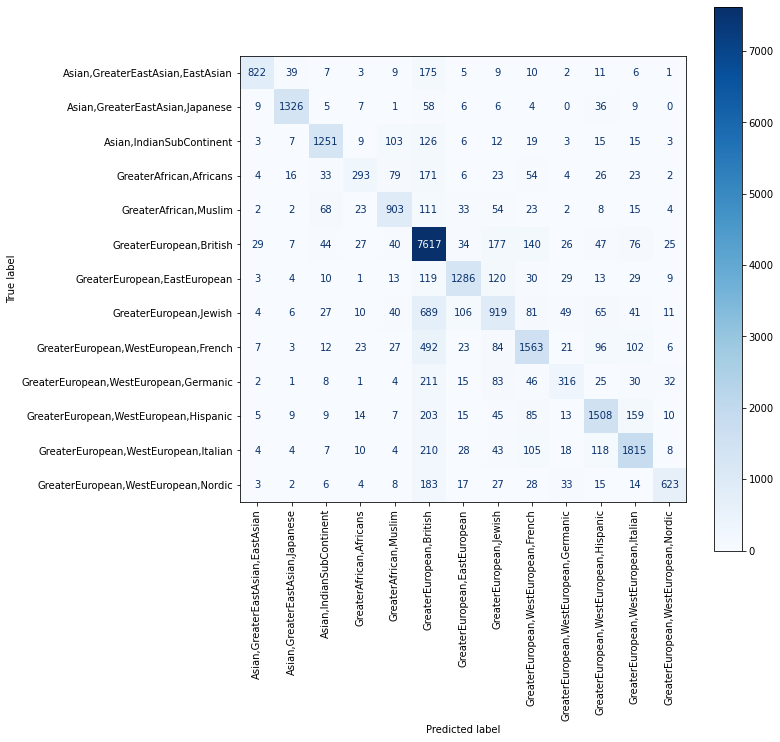

In [7]:
print('Predict...')
y_pred = model.predict(X_test)
score = model.score(X_test, y_test)
print('Test score = %f' % score)

target_names = list(sdf.race.astype('category').cat.categories)
print(classification_report(y_test, y_pred, target_names=target_names))

# plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(model, X_test, y_test, display_labels=target_names, 
                      ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)
plt.show()

## Test queries

In [8]:
test_names = ['_abe_shinzo__', '_xi_jinping__', '_netanyahu_benjamin__', '_putin_vladimir__',
              '_obama_barrack__', '_modi_narendra__', '_conte_giuseppe__', '_johnson_boris__']

X_query = vect.transform(test_names).toarray()
y_query = model.predict(X_query)

print(y_query)
print([target_names[i] for i in y_query])

[ 1  0  7  6  3  2 11  5]
['Asian,GreaterEastAsian,Japanese', 'Asian,GreaterEastAsian,EastAsian', 'GreaterEuropean,Jewish', 'GreaterEuropean,EastEuropean', 'GreaterAfrican,Africans', 'Asian,IndianSubContinent', 'GreaterEuropean,WestEuropean,Italian', 'GreaterEuropean,British']


## Save model

In [9]:
import pickle
from joblib import dump, load

tfidf_filename = '../models/wiki/logistic_regression/tfidf.pkl'
model_filename = '../models/wiki/logistic_regression/wiki_name_logreg.joblib'

dump(model, model_filename)
pickle.dump(vect, open(tfidf_filename, 'wb'))


## Load model

In [10]:
# load model
loaded_model = load(model_filename)

# load vectorizer
tf1 = pickle.load(open(tfidf_filename, 'rb'))
loaded_vect = TfidfVectorizer(vocabulary=tf1.vocabulary_, analyzer='char', ngram_range=(min_ngrams, max_ngrams), lowercase=True)